In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import plotly.graph_objects as go
import plotly.express as px

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
bounce_data = pd.read_csv('../../data/bounce_rates_sim.csv')
bounce_data['county'] = bounce_data.county.astype('category')

In [18]:
bounce_data.head()

bounce_time  age county   std_age
0   225.853772   54   kent  0.222161
1   217.906225   79   kent  1.335143
2   220.660096   71   kent  0.978989
3   223.420578   47   kent -0.089474
4   213.887774   93   kent  1.958414

#### Center-Scale 

In [4]:
bounce_data['std_age'] = (bounce_data.age - bounce_data.age.mean())/ bounce_data.age.std()

In [19]:
bounce_data.describe()

bounce_time         age       std_age
count   613.000000  613.000000  6.130000e+02
mean    199.977340   49.009788 -9.272988e-17
std      14.859146   22.462166  1.000000e+00
min     156.012899   -1.000000 -2.226401e+00
25%     190.309580   32.000000 -7.572639e-01
50%     202.567676   48.000000 -4.495505e-02
75%     210.770395   66.000000  7.563924e-01
max     234.455117  129.000000  3.561109e+00

# EDA

### Simple linear regression

In [20]:
X = bounce_data.std_age.values.reshape(-1,1)
y = bounce_data.bounce_time.values

lr = LinearRegression().fit(X,y)

y0 = lr.intercept_ + X.min()*lr.coef_
y1 = lr.intercept_ + X.max()*lr.coef_

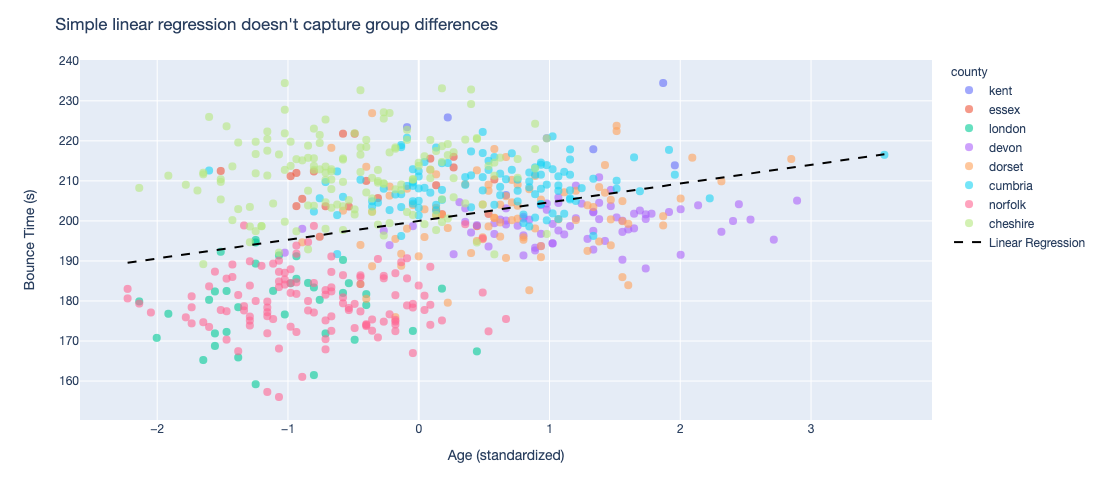

In [299]:
fig = px.scatter(x='std_age', y='bounce_time', 
           data_frame=bounce_data, color='county')

fig.update_traces(marker=dict(size=8, opacity=0.6),
                  selector=dict(mode='markers'))

fig.add_trace(go.Scatter(x=[X.min(), X.max()], y=np.hstack([y0, y1]), mode='lines', 
                        name="Linear Regression", 
                        marker_color='black',
                        line_dash='dash'))

fig.update_layout(autosize=False,
                  width=900,
                  height=500,
                  title="Simple linear regression doesn't capture group differences",
                  xaxis_title="Age (standardized)",
                  yaxis_title="Bounce Time (s)",
                  font=dict(family="Helvetica Neue"))

fig.show()

### Individual trendlines

#### Plotly

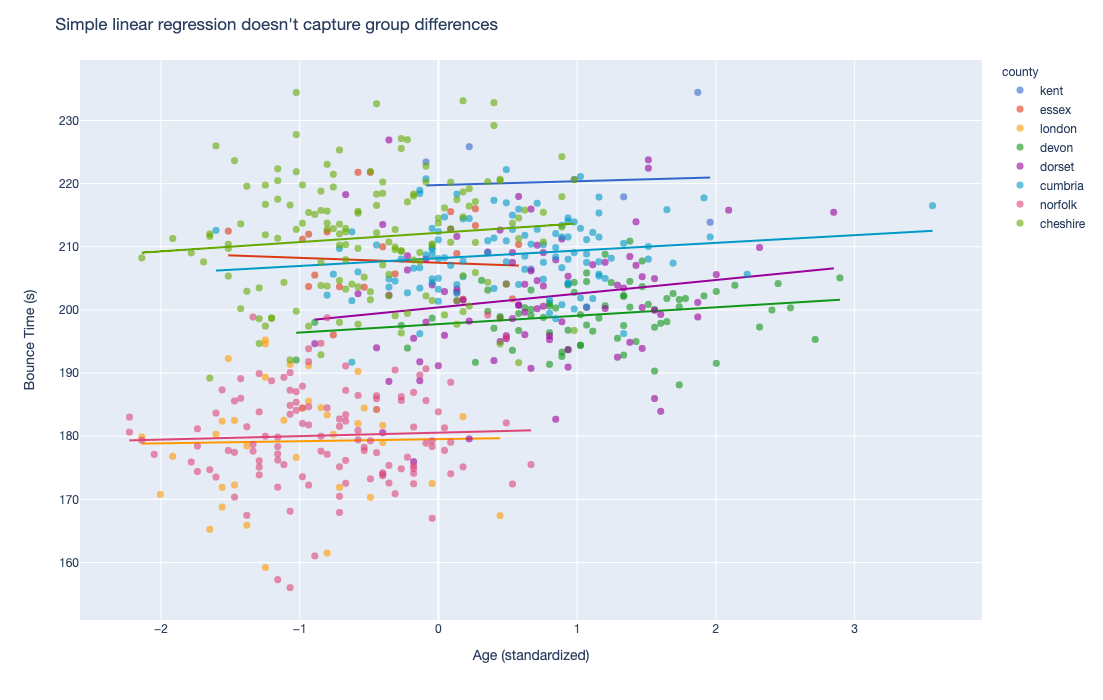

In [300]:
fig = px.scatter(x='std_age', y='bounce_time', 
                 data_frame=bounce_data, color='county',
                 trendline='ols', color_discrete_sequence=px.colors.qualitative.G10)

fig.update_traces(overwrite=True, marker_size=7, marker_opacity=0.6,
                  selector=dict(mode='markers'))

fig.update_layout(autosize=False,
                  width=900,
                  height=700,
                  title="Simple linear regression doesn't capture group differences",
                  xaxis_title="Age (standardized)",
                  yaxis_title="Bounce Time (s)",
                  font=dict(family="Helvetica Neue"))

#### Seaborn

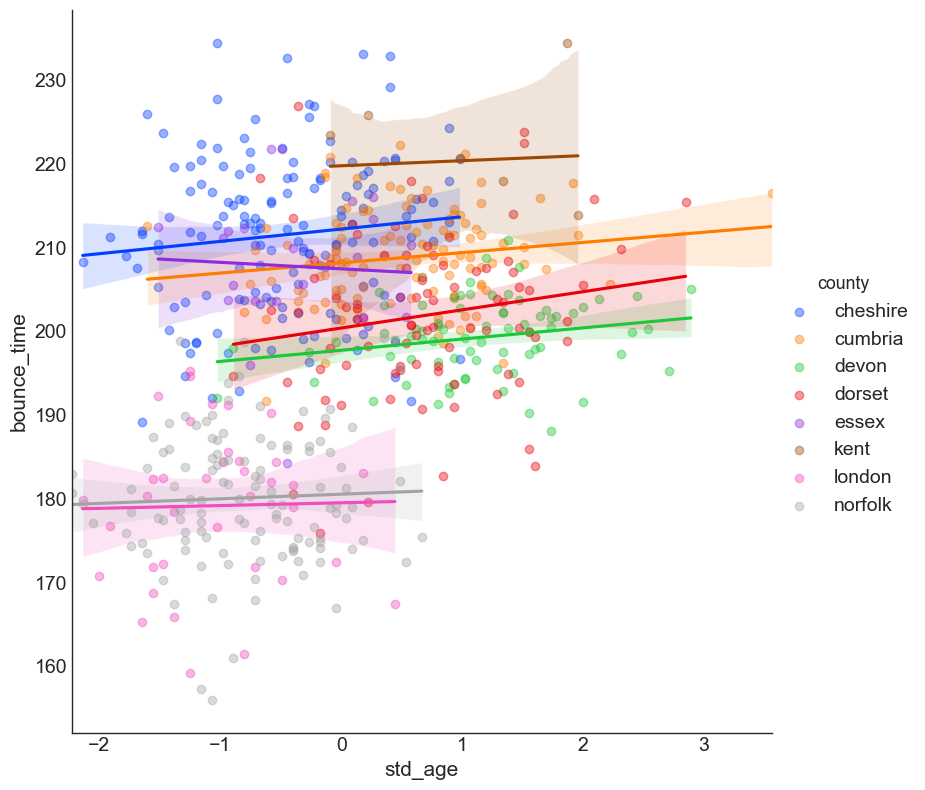

In [23]:
sns.set_style("ticks")
sns.lmplot(x='std_age', y='bounce_time',
          hue='county', data=bounce_data, height=8, ci=95,
          palette='bright',
          scatter_kws=dict(alpha=0.4))
pass

## Bayesian modeling

### Prior Predictive Checks

In [17]:
county_idx = bounce_data.county.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
y_obs = bounce_data.bounce_time.values

prior_sims = pd.DataFrame()

for i in range(20):
    np.random.seed(i)
    # Priors
    tau0 = np.abs(np.random.normal(loc=0.0, scale=10.0, size=1))
    tau1 = np.abs(np.random.normal(loc=0.0, scale=10.0, size=1))

    # Noise
    sigma = np.abs(np.random.normal(loc=0.0, scale=100.0, size=1))
    sigma_vec = np.random.normal(loc=0.0, scale=sigma, size=bounce_data.shape[0])

    # Random effects
    b0 = np.random.normal(loc=0.0, scale=tau0, 
                          size=len(bounce_data.county.unique()))
    b1 = np.random.normal(loc=0.0, scale=tau1, 
                          size=len(bounce_data.county.unique()))

    # Fixed effects
    beta0 = np.random.normal(loc=200.0, scale=1.0, size=1)
    beta1 = np.random.normal(loc=4, scale=1.0, size=1)

    sim_data = beta0 + b0[county_idx] + (b1[county_idx] + beta1)*bounce_data.std_age.values + sigma_vec
    
    ys = np.c_[y_obs, sim_data]
    
    tmp = pd.DataFrame(ys, columns=['obs','sim'])
    tmp['sim_no'] = i
    
    prior_sims = prior_sims.append(tmp)



In [ ]:
prior_fig = px.scatter(x='obs', y='sim', 
                       animation_frame='sim_no', data_frame=prior_sims,
                      range_y=[-50,500])

prior_fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1800

prior_fig.update_layout(autosize=False,
                  width=700,
                  height=700,
                  title="Examples of samples generated via priors across simulations",
                  xaxis_title="Bounce Time (s)",
                  yaxis_title="Simulated Bounce Time (s)",
                  font=dict(family="Helvetica Neue"))


## Bayesian Modeling

### Simple linear regression

$$y_i \sim N(\beta_0 + \beta_1*x_i, \sigma^2)\\ \text{ given } \epsilon_i \sim N(0, \sigma^2)$$

with the following priors

$$\beta_0 \sim N(200,1), \; \beta_1 \sim N(4,1), \; \sigma^2 \sim N_+(0,100)$$

In [5]:
std_age_vals = bounce_data.std_age.values
bounce_time = bounce_data.bounce_time.values

In [6]:

with pm.Model() as lin_reg:
    # Set priors
    priors = {'Intercept': pm.Normal.dist(mu=200, sigma=1),
             'std_age': pm.Normal.dist(mu=4, sigma=1),
             'sigma': pm.TruncatedNormal.dist(mu=0, sigma=100, lower=0)}
    
    # Set formula
    pm.GLM.from_formula('bounce_time ~ std_age', 
                        data=bounce_data, 
                        priors=priors)
    
    # Specify sampling with NUTs HMC
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    lr_trace = pm.sample(4000, tune=1000, start=start, step=step, # burn-in 1000 iterations + 4000 samples
                         random_seed=123, 
                         cores=2, chains=2)

    
    prior_pred = pm.sample_prior_predictive() # sample prior predictive
    post_pred = pm.sample_posterior_predictive(lr_trace) # burn-in 1000 iterations

    # Convert to arviz InferenceData type
    lr_data = az.from_pymc3(
        trace=lr_trace,
        prior=prior_pred,
        posterior_predictive=post_pred
    )

logp = -2,497.4, ||grad|| = 0.00013802: 100%|██████████| 22/22 [00:00<00:00, 1786.47it/s]  
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, std_age, Intercept]
INFO:pymc3:NUTS: [sd, std_age, Intercept]
100%|██████████| 8000/8000 [00:09<00:00, 870.58it/s]


#### Divergence Diagnostic

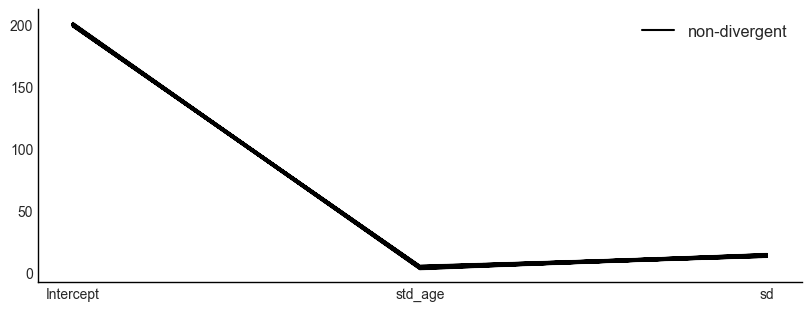

In [24]:
plt.style.use('arviz-white')
pm.plot_parallel(lr_data, var_names=['Intercept', 'std_age', 'sd'],
                 figsize=(8,3),
                 show=True, legend=True)
pass

#### Traceplot Diagnostic

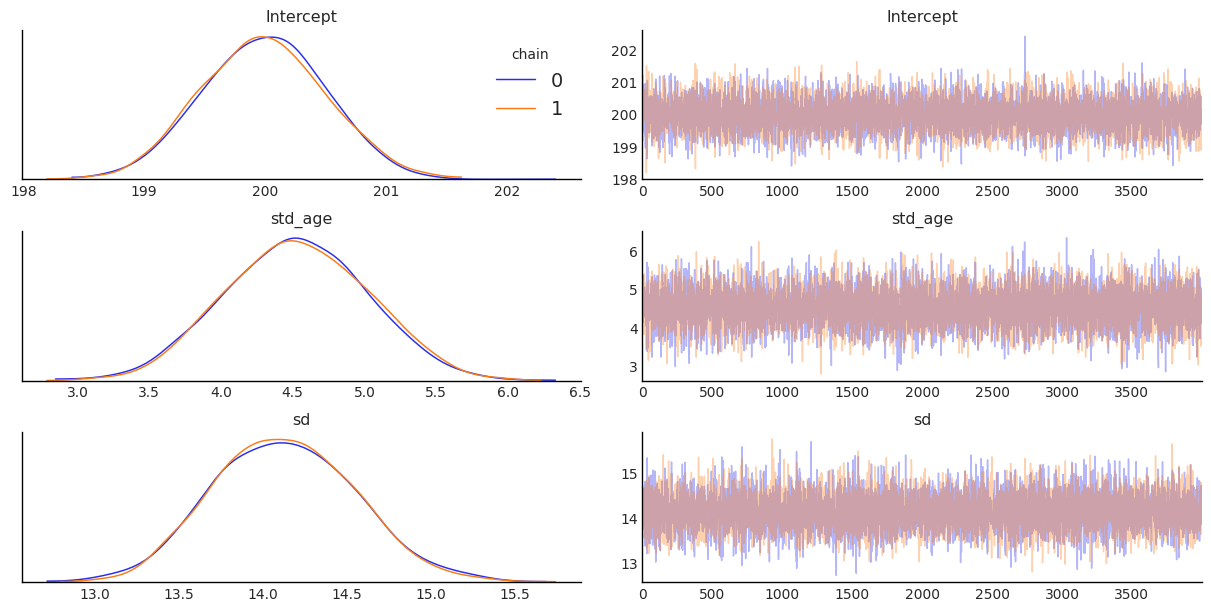

In [8]:
plt.style.use('arviz-colors')
pm.traceplot(lr_trace, compact=False, 
             legend=True, 
             show=True)
pass

#### ACF Diagnostic

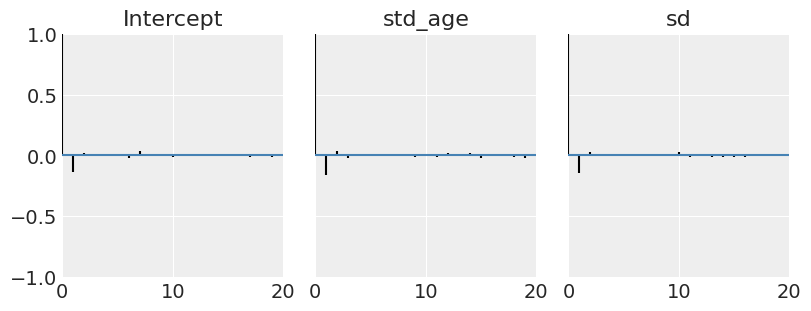

In [9]:
plt.style.use('arviz-darkgrid')
pm.autocorrplot(lr_trace, max_lag=20, 
                combined=True,
                figsize=(8,3),
                show=True)
pass

### Random Intercept

**Parametrization is a bit different to that in the article or the R file to avoid autocorrelation, however they all are the same (i.e. a mean centered parametrization)**

$$y_{ij} \sim N(\alpha_j + \beta_1x_i, \sigma^2)\\ \text{ given } \quad \alpha_j \sim N(\mu_0, \tau_0^2) \perp \epsilon_{ij} \sim N(0, \sigma^2)$$

with the following priors for fixed effects

$$\beta_1 \sim N(4,1), \; \sigma^2 \sim N_+(0,100)$$

and random effect hyperpriors
$$\mu_0 \sim N(200,1), \; \tau_0^2 \sim N_+(0, 10)$$

In [25]:
n_counties = len(np.unique(county_idx))
std_age = bounce_data.std_age.values

In [26]:

with pm.Model() as bayes_rintercept:
    # Set hyper-priors
    mu0 = pm.Normal('mu0', mu=200, sigma=1) # This can be interpretated as ybar bounce time
    tau0 = pm.TruncatedNormal('sd_Intercept', mu=0, sigma=10, lower=0)
    
    # Random Intercept
    a = pm.Normal('a', mu=mu0, sigma=tau0, shape=n_counties)
    
    # Fixed slope
    beta1 = pm.Normal('std_age', mu=4, sigma=1)
    
    # Distribution mean
    y_hat = a[county_idx] + beta1*std_age
    
    # Population variance
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=100, lower=0)
    
    # Likelihood function
    y = pm.Normal('y', mu=y_hat, sigma=sigma, observed=y_obs)
    
    # Specify sampling with NUTs HMC
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    rint_trace = pm.sample(4000, tune=1000, start=start, step=step, # burn-in 1000 iterations + 4000 samples
                           random_seed=123, cores=2, 
                           chains=2)

    prior_pred = pm.sample_prior_predictive() # sample prior predictive
    post_pred = pm.sample_posterior_predictive(rint_trace) # sample posterior predictions

    # Convert to arviz InferenceData type
    rint_data = az.from_pymc3(
        trace=rint_trace,
        prior=prior_pred,
        posterior_predictive=post_pred,
        coords={"county_data": bounce_data.county.values,
               "county_reff": bounce_data.county.cat.categories.values},
        dims={"a": ["county_reff"], "y": ["county_data"]}
    )
    

logp = -2,180, ||grad|| = 0.048366: 100%|██████████| 149/149 [00:00<00:00, 1366.34it/s] 
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, std_age, a, sd_Intercept, mu0]
INFO:pymc3:NUTS: [sigma, std_age, a, sd_Intercept, mu0]
100%|██████████| 8000/8000 [00:08<00:00, 896.51it/s]


#### Divergence Diagnostics

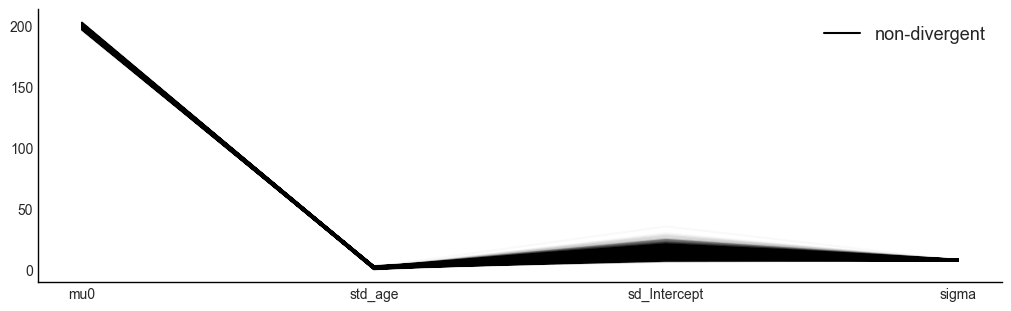

In [27]:
plt.style.use('arviz-white')
pm.plot_parallel(rint_data, figsize=(10,3), var_names=["~^a"], 
                 filter_vars="regex",
                 show=True, legend=True)
pass

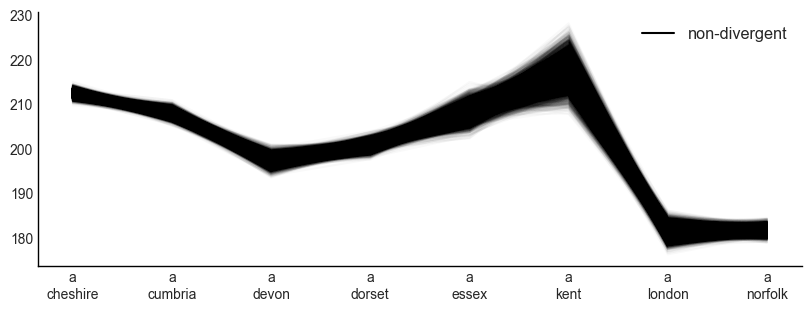

In [28]:
plt.style.use('arviz-white')
pm.plot_parallel(rint_data, figsize=(8,3), filter_vars='regex', 
                 var_names=['^a'], show=True, 
                 legend=True)
pass

#### Traceplot Diagnostics

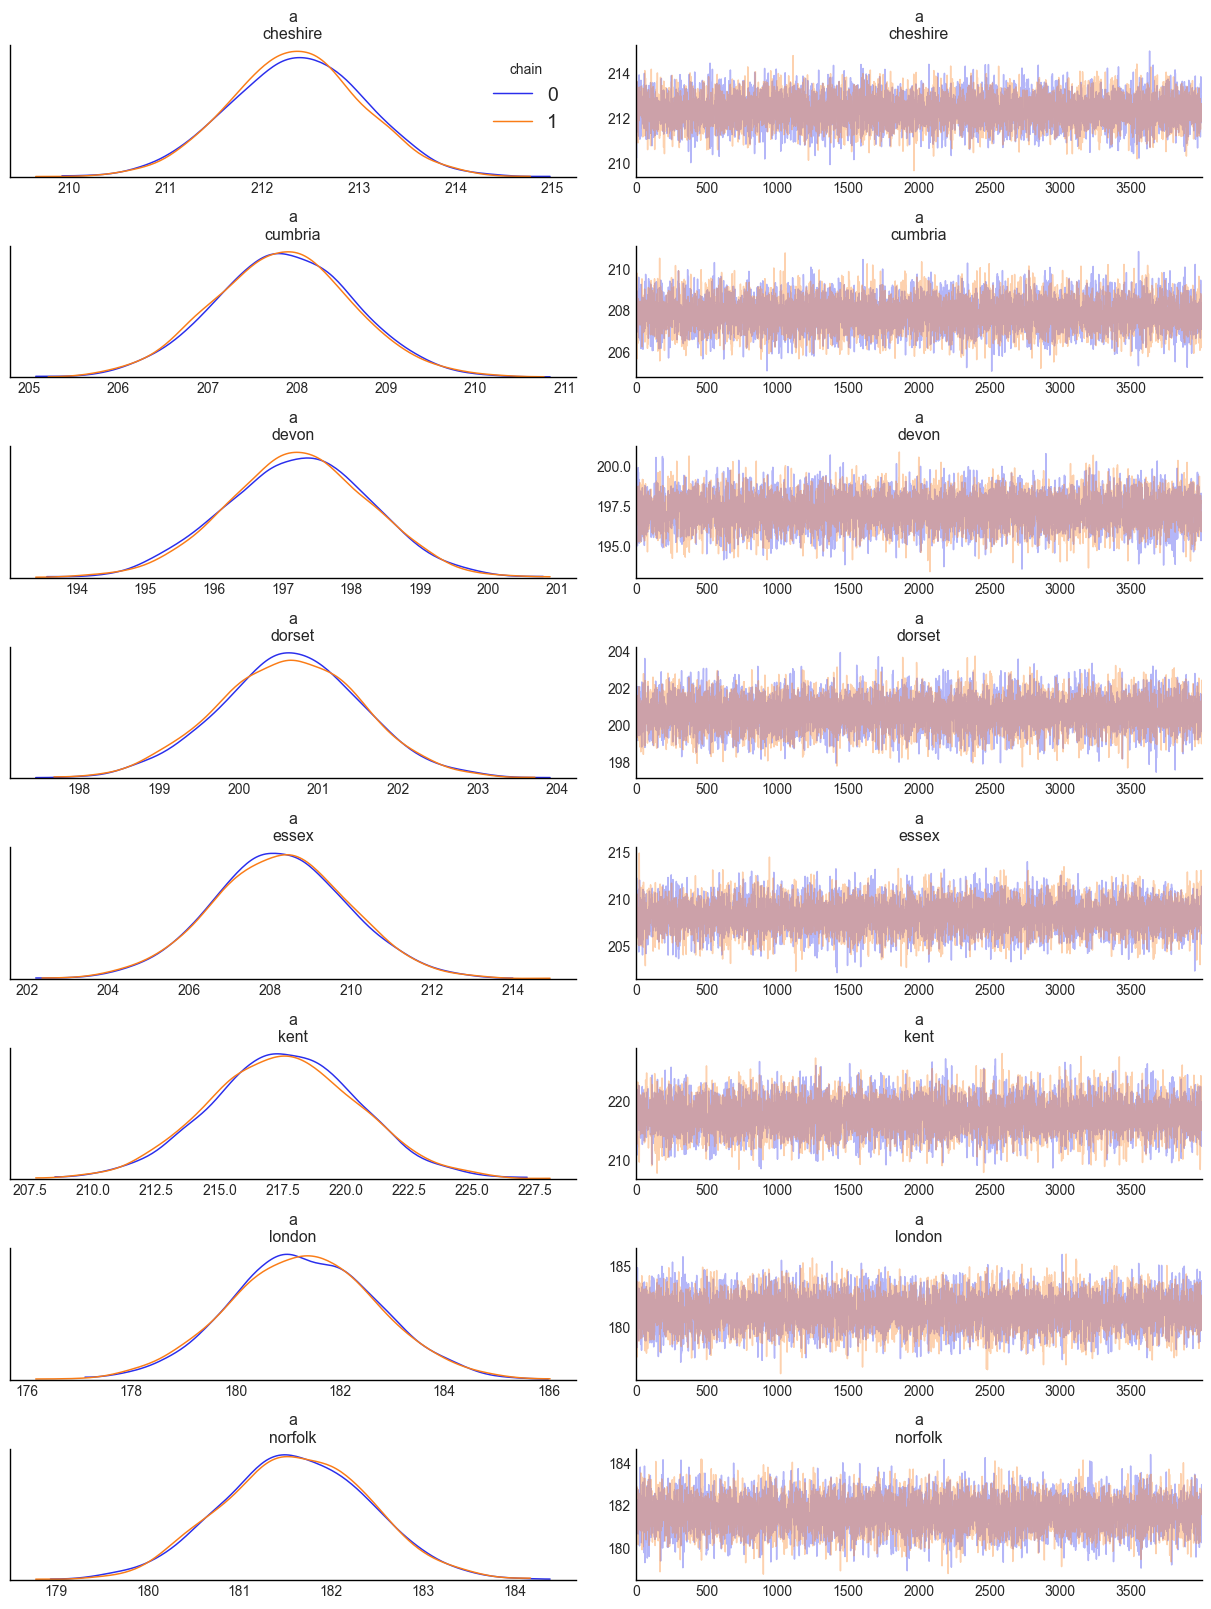

In [29]:
plt.style.use('arviz-colors')
pm.traceplot(rint_data, compact=False, var_names=['^a'], filter_vars='regex',
             legend=True, show=True)
pass

#### ACF Diagnostics

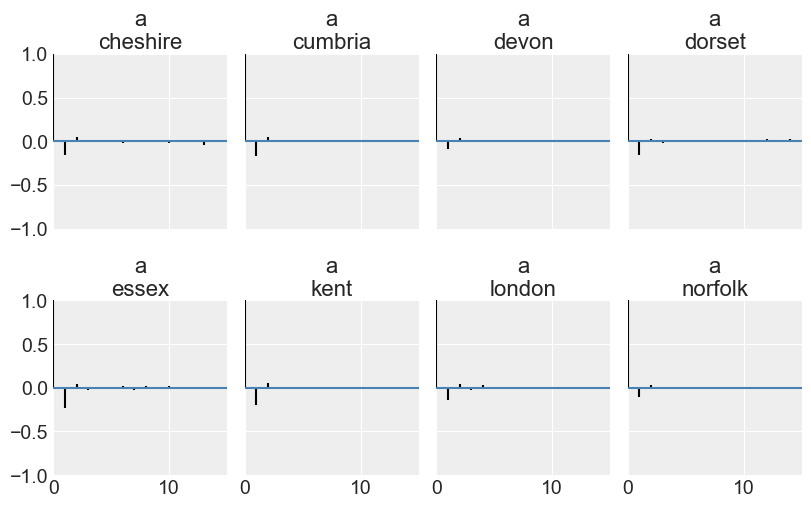

In [30]:
plt.style.use('arviz-darkgrid')
pm.autocorrplot(rint_data,combined=True, var_names=['^a'], filter_vars='regex',
               show=True, max_lag=15,
               figsize=(8,5))
pass

### Random Intercept + Slope

**Again parametrization is a bit different to that in the article or the R file, in this case we use a *non-centered parametrization* to avoid problems with convergence and help the sampling given we have small number of groups and within-group variance is high**

I've provided both parametrizations given the centered parametrization could be useful for situations with larger number of groups and/or smaller within-group variance.


**Centered parametrization**
$$y_{ij} \sim N(\alpha_j + \beta_jx_i, \sigma^2)$$
$$\text{ given } \quad \begin{pmatrix}\alpha_j \\ \beta_j \end{pmatrix} \sim N\left(\begin{pmatrix}\mu_\alpha\\ \mu_\beta \end{pmatrix},  \boldsymbol{\Omega}\right) \perp \epsilon_{ij} \sim N(0, \sigma^2)$$

$$\Omega = \begin{pmatrix} \tau^2_\alpha && \tau_{\alpha, \beta}\\ \tau_{\beta,\alpha} && \tau^2_\beta \end{pmatrix}$$
with the following priors for fixed effects

$$\sigma^2 \sim N_+(0,100)$$

and  random effect hyperpriors 
$$\mu_\alpha \sim N(200,1), \; \mu_\beta \sim N(4,1), \; \tau_\alpha^2 \sim N_+(0, 10), \tau_\beta^2 \sim N_+(0, 10)$$


**Non-centered parametrization**

Rather than letting the random effects be distributed normal centered at group mean $\mu_\cdot$ (which can get stuck near this group mean when $\tau_\cdot \rightarrow 0$), we say they are offset from the group mean by some amount $\tilde{\mu}_\cdot$. How much these deviate will now depend on the offset and the variance which acts as a scaling factor. Thus in essence we allow the group mean $\mu_\cdot$ and variance $\tau_\cdot$ to be independent *a priori*

$$y_{ij} \sim N(\alpha_j + \beta_jx_i, \sigma^2)$$

$$\alpha_j = \mu_\alpha + \tau_\alpha*\tilde{\mu_\alpha} \quad \text{ where } \tilde{\mu_\alpha} \sim N(0, 1) $$

$$\beta_j = \mu_\beta + \tau_\beta*\tilde{\mu_\beta} \quad \text{ where } \tilde{\mu_\beta} \sim N(0, 1) $$


with the following priors for fixed effects

$$\sigma^2 \sim N_+(0,100)$$

and  random effect hyperpriors 
$$\mu_\alpha \sim N(200,1), \; \mu_\beta \sim N(4,1), \; \tau_\alpha^2 \sim N_+(0, 10), \tau_\beta^2 \sim N_+(0, 10)$$


In [31]:
with pm.Model() as bayes_rslope:
    # Set hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=200, sigma=1) # This can be interpretated as ybar bounce time
    tau_a = pm.TruncatedNormal('sd_alpha', mu=0, sigma=10, lower=0)
    mu_b = pm.Normal('mu_beta', mu=4, sigma=1)
    tau_b = pm.TruncatedNormal('sd_beta', mu=0, sigma=10, lower=0)
    
    # Non-centered Random Intercept
    a_off = pm.Normal('a_off', mu=0, sigma=1, shape=n_counties)
    a = pm.Deterministic('alpha', mu_a + a_off*tau_a)
    
    # Non-centered Random slope
    b_off = pm.Normal('b_off', mu=0, sigma=1, shape=n_counties)
    b = pm.Deterministic('beta', mu_b + b_off*tau_b)

    # Likelihood mean and variance
    y_hat = a[county_idx] + b[county_idx]*std_age
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=100, lower=0)
    
    y = pm.Normal('y', mu=y_hat, sigma=sigma, observed=y_obs)
    
    # Specify sampling with NUTs HMC
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    rslope_trace = pm.sample(4000, tune=1000, start=start, step=step, # burn-in 1000 iterations + 4000 samples
                           random_seed=123, cores=2, 
                           chains=2)

    prior_pred = pm.sample_prior_predictive() # sample prior predictive
    post_pred = pm.sample_posterior_predictive(rslope_trace) 

    # Convert to arviz InferenceData type
    rslope_data = az.from_pymc3(
        trace=rslope_trace,
        prior=prior_pred,
        posterior_predictive=post_pred,
        coords={"county_data": bounce_data.county.values,
               "county_reff": bounce_data.county.cat.categories.values},
        dims={"alpha": ["county_reff"], "beta":["county_reff"], "y": ["county_data"]}
    )
    

logp = -2,165.4, ||grad|| = 0.095467: 100%|██████████| 160/160 [00:00<00:00, 1220.98it/s] 
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_off, a_off, sd_beta, mu_beta, sd_alpha, mu_alpha]
INFO:pymc3:NUTS: [sigma, b_off, a_off, sd_beta, mu_beta, sd_alpha, mu_alpha]
100%|██████████| 8000/8000 [00:17<00:00, 457.12it/s]


#### Divergence Diagnostics

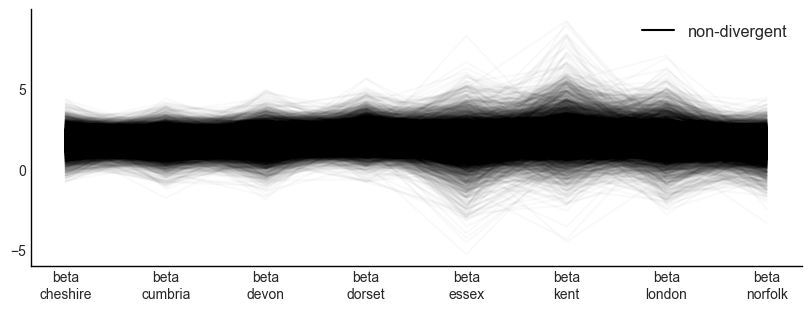

In [32]:
plt.style.use('arviz-white')
pm.plot_parallel(rslope_data, figsize=(8,3), filter_vars='regex', 
                 var_names=['^beta'], show=True, 
                 legend=True)
pass

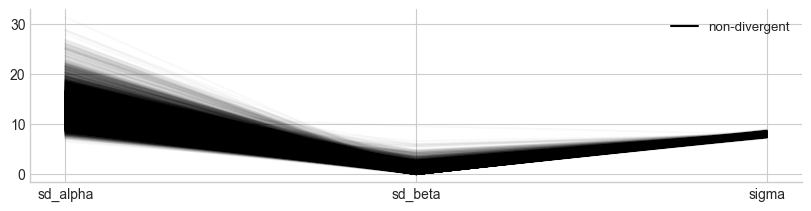

In [33]:
plt.style.use('arviz-whitegrid')
pm.plot_parallel(rslope_data, figsize=(8,2), filter_vars='regex', 
                 var_names=['^s'], show=True, 
                 legend=True)
pass

#### Traceplot Diagnostics

Notice some potential issues in the `sd_beta` mixing, it seems to be high at certain areas (i.e. spikes) which might be due to most of variance being explained by the random intercept in the small number of groups we have in this example.


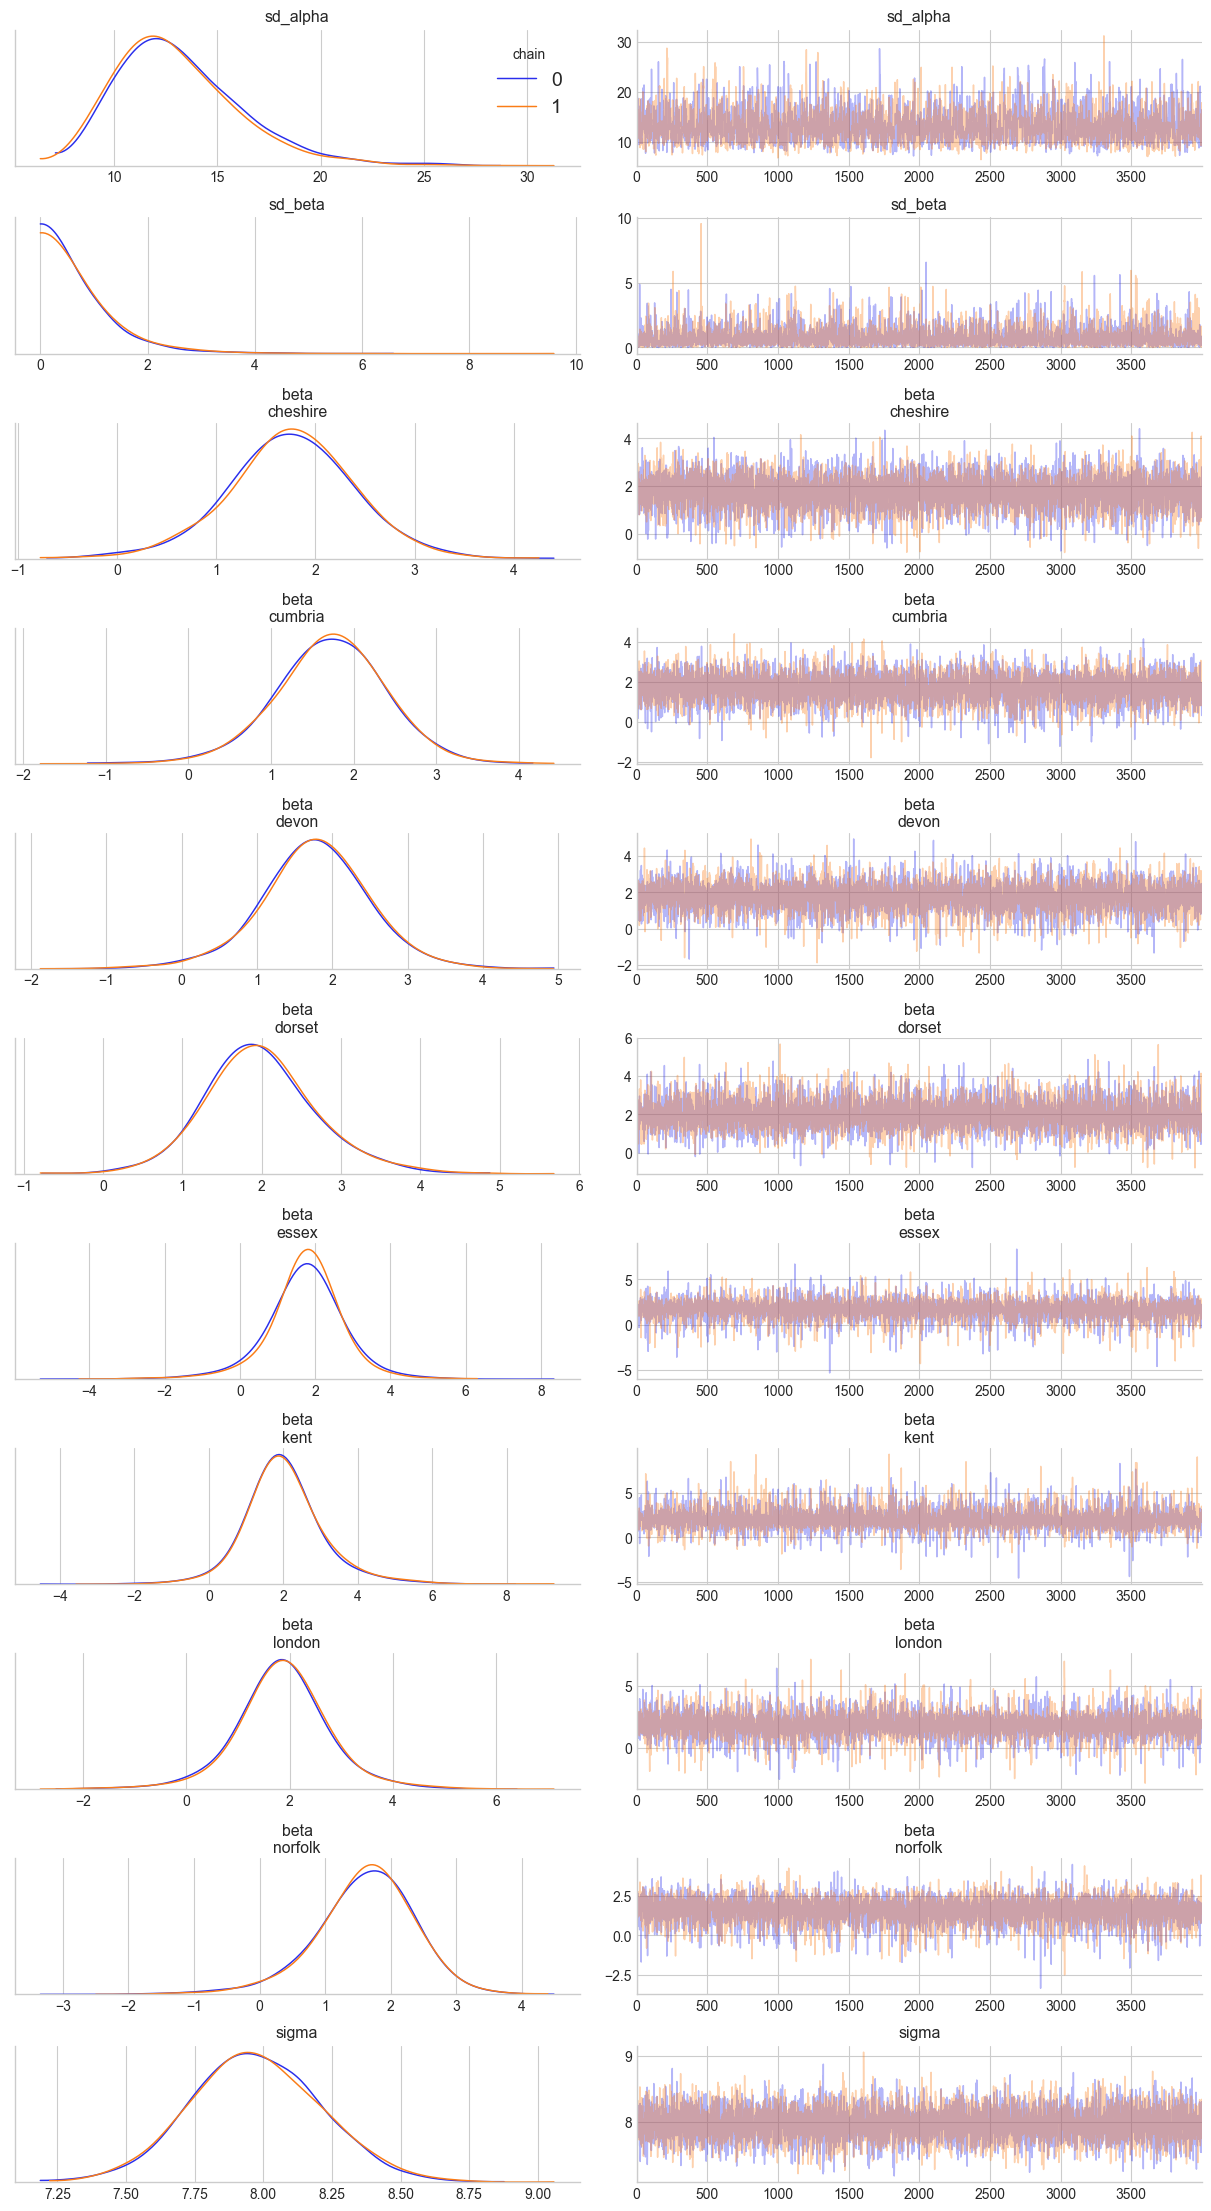

In [34]:
plt.style.use('arviz-colors')
pm.traceplot(rslope_data,compact=False, var_names=['^beta', '^s'], filter_vars='regex',
             legend=True, show=True)
pass

#### ACF Diagnostics

We notice some of the same issues on the `sd_alpha` and `sd_beta` ACF plots as in their traceplots. These aren't significant, some thinning of the samples might help mitigate these issues.


(I didn't try this here since I know the random slope won't be the best model in this case)

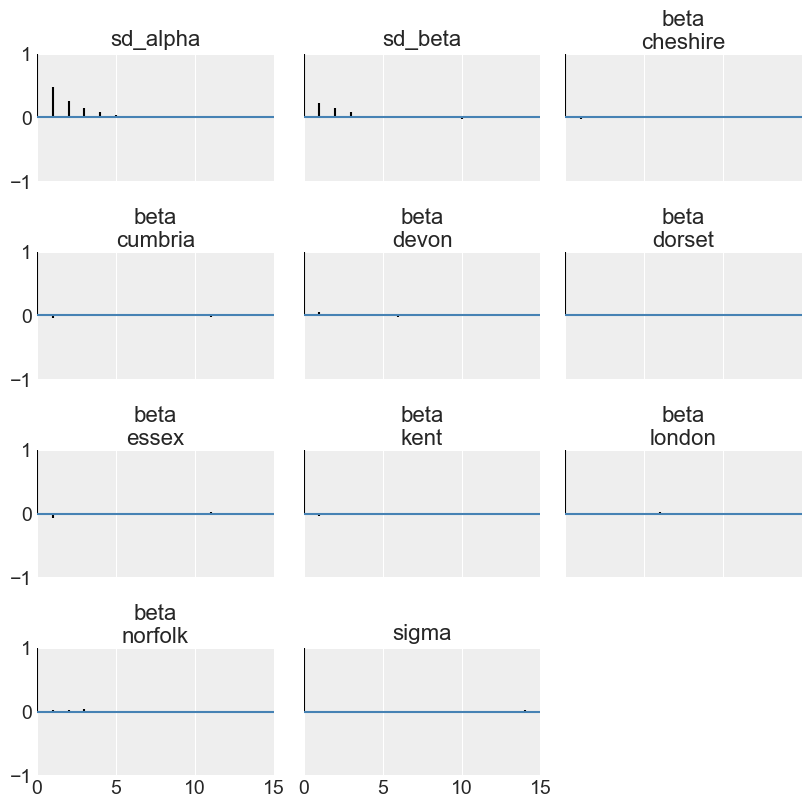

In [35]:
plt.style.use('arviz-darkgrid')
pm.autocorrplot(rslope_data,combined=True, var_names=['^beta', '^s'], filter_vars='regex',
                show=True, max_lag=15,
               figsize=(8,8))
pass

# Model Comparison

## Posterior Predictive Checks (PPC)

### Posterior Density

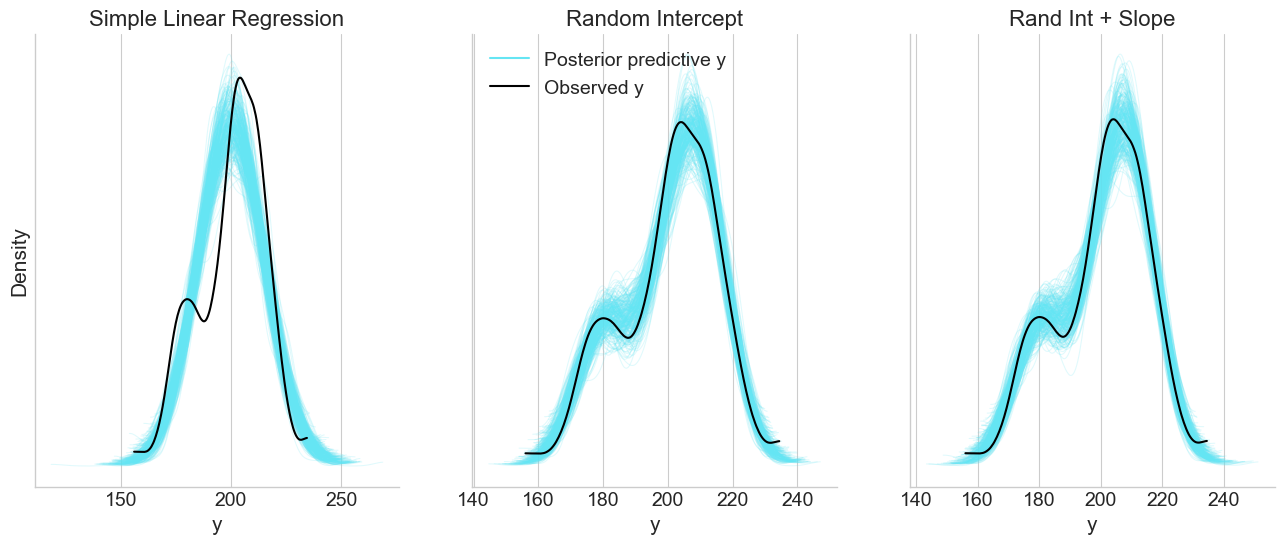

In [514]:
# use default pymc3 plot_ppc function
plt.style.use('arviz-colors')
fig, ax = plt.subplots(1,3, figsize=(16,6))
pm.plot_ppc(lr_data, ax=ax[0], legend=False, 
            num_pp_samples=300, mean=False)
pm.plot_ppc(rint_data, ax=ax[1], num_pp_samples=300, mean=False)
pm.plot_ppc(rslope_data, ax=ax[2], legend=False, num_pp_samples=300, mean=False)

ax[1].legend(loc=2)
ax[0].set_ylabel("Density")
ax[0].set_title("Simple Linear Regression")
ax[1].set_title("Random Intercept")
ax[2].set_title("Rand Int + Slope")
pass

### PPC Summary Statistics

In [38]:
# Get 1000 posterior samples (y_rep) per model

ppc_lr = pm.sample_posterior_predictive(lr_trace, samples=1000, 
                                        model=lin_reg, random_seed=123)

ppc_rint = pm.sample_posterior_predictive(rint_trace, samples=1000, 
                                        model=bayes_rintercept, random_seed=123)

ppc_rslope = pm.sample_posterior_predictive(rslope_trace, samples=1000, 
                                        model=bayes_rslope, random_seed=123)


100%|██████████| 1000/1000 [00:02<00:00, 432.37it/s]


#### Posterior Predictive Skewness 

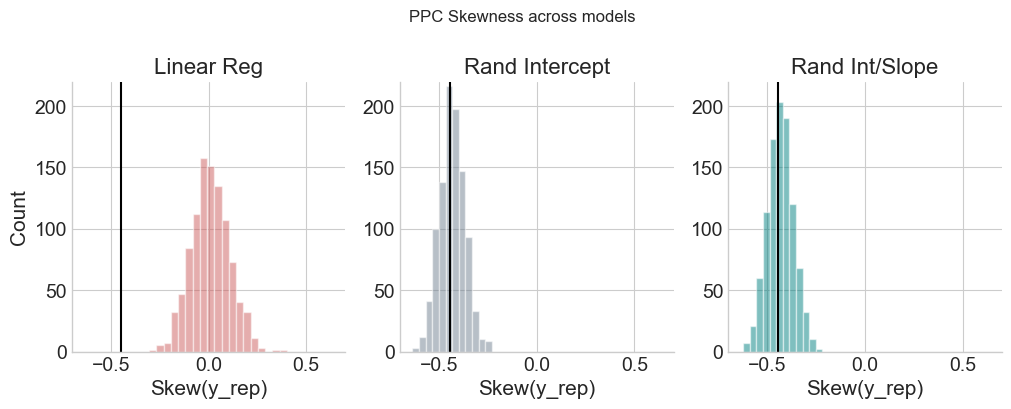

In [510]:
# Build helper function to compute skewness according to NIST
def skew(y):
    '''Compute Fisher-Pearson skew coefficient for values of y'''
    n = len(y)
    dif = y - y.mean()
    skew_stat = (np.sqrt(n-1)/(n-2))*n*(np.sum(dif**3)/(np.sum(dif**2)**1.5))
    return skew_stat

# Plot custom figures 
plt.style.use("arviz-whitegrid")
fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].hist([skew(y) for y in ppc_lr['y']], bins=19, alpha=0.5, color="indianred")
ax[1].hist([skew(y) for y in ppc_rint['y']], bins=12, alpha=0.5, color='slategray')
ax[2].hist([skew(y) for y in ppc_rslope['y']], bins=12, alpha=0.5, color='teal')

# update figure titles
title = ['Linear Reg', 'Rand Intercept', 'Rand Int/Slope']
ax[0].set_ylabel('Count')
plt.subplots_adjust(top=0.8)
fig.suptitle('PPC Skewness across models')

# Add observed skewness to each plot
for i, f in enumerate(ax):
    f.axvline(skew(y_obs), color='black')
    f.set(xlim=(-0.7, 0.7), ylim=(0, 220),
         xlabel='Skew(y_rep)', title=title[i])

pass

#### Posterior Predictive Group Medians

In [515]:
# get county observed median value
county_obs_medians = bounce_data.groupby('county').median()['bounce_time'].values

# Custom function to obtain posterior predicted medians per county
def county_ppc_stats(ppc, data, var='y', np_metric=np.median):
    """Computes the county median for each posterior predicted draw from a given model"""
    df = pd.DataFrame(np.asarray(ppc[var]).T)
    df['county'] = data['county']
    
    df = df.groupby('county').apply(np_metric, axis=0).apply(pd.Series)
    
    return df.T.melt(value_name='y_rep')
    
# Assign to data frames
lr_df = county_ppc_stats(ppc_lr, bounce_data)
rint_df = county_ppc_stats(ppc_rint, bounce_data)
rslope_df = county_ppc_stats(ppc_rslope, bounce_data)

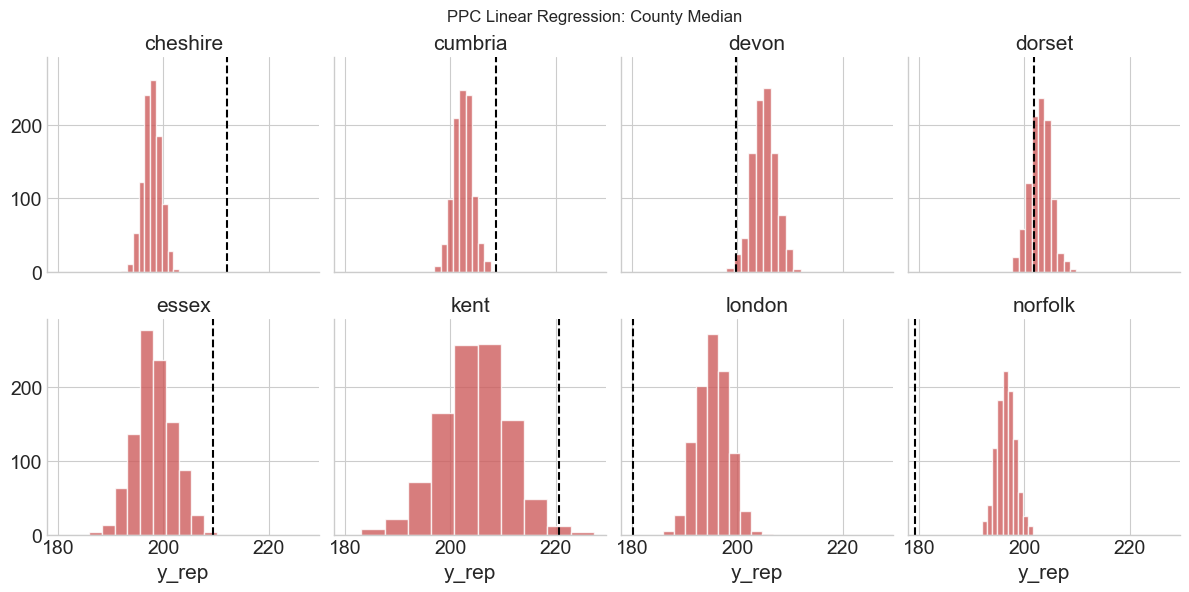

In [516]:
# use seaborn facetgrid to plot county specific median posteriors vs observed
plt.style.use('arviz-whitegrid')
g1 = sns.FacetGrid(lr_df, col="county", margin_titles=True, col_wrap = 4)
g1.map(plt.hist, "y_rep", color="indianred", alpha=0.8).set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g1.fig.suptitle('PPC Linear Regression: County Median')

# Add county specific observed medians
for i, ax in enumerate(g1.axes):
    ax.axvline(county_obs_medians[i], color='black', ls='--')



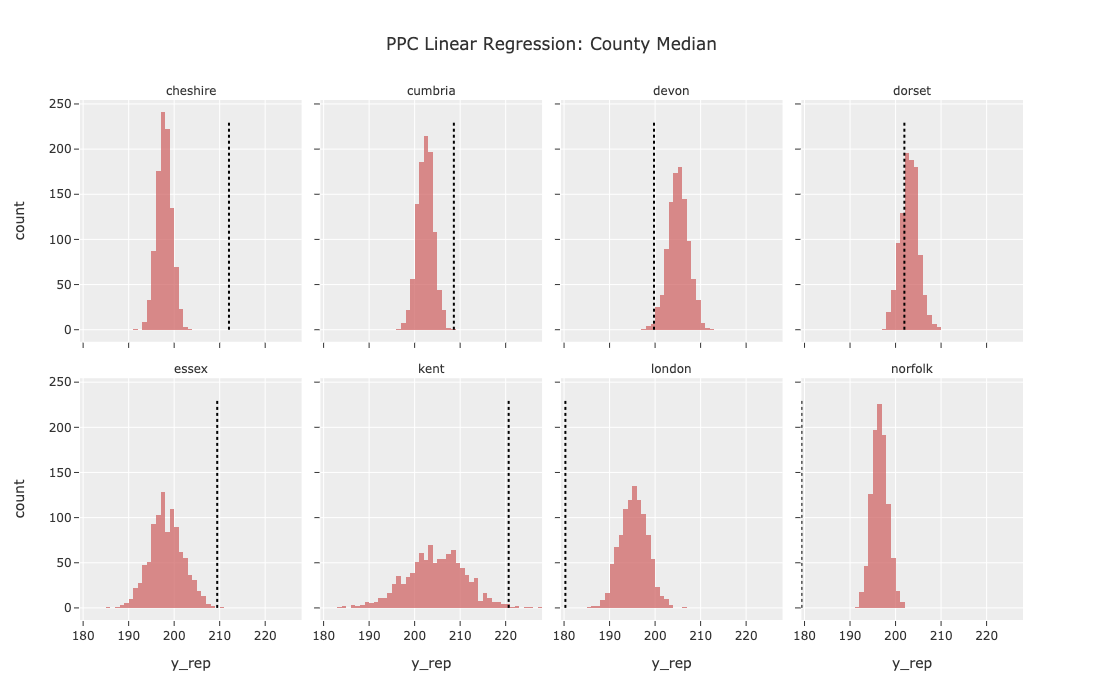

In [341]:
# In Plotly express to do the same,
fig = px.histogram(data_frame=lr_df, x='y_rep', facet_col='county', facet_col_wrap=4, 
                   nbins=50, color='county', color_discrete_sequence=['indianred'], opacity=0.7,
                   template='ggplot2', title='PPC Linear Regression: County Median',
                   width=1000, height=700)

# Add county specific medians
for i, m in enumerate(county_obs_medians[:4]):
    fig.add_scatter(x=[m, m], y=[0,230], mode='lines', 
                    row=2, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )
    
for i, m in enumerate(county_obs_medians[4:]):
    fig.add_scatter(x=[m, m], y=[0,230], mode='lines', 
                    row=1, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )

# remove legends and clean up column names
fig.update_traces(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))


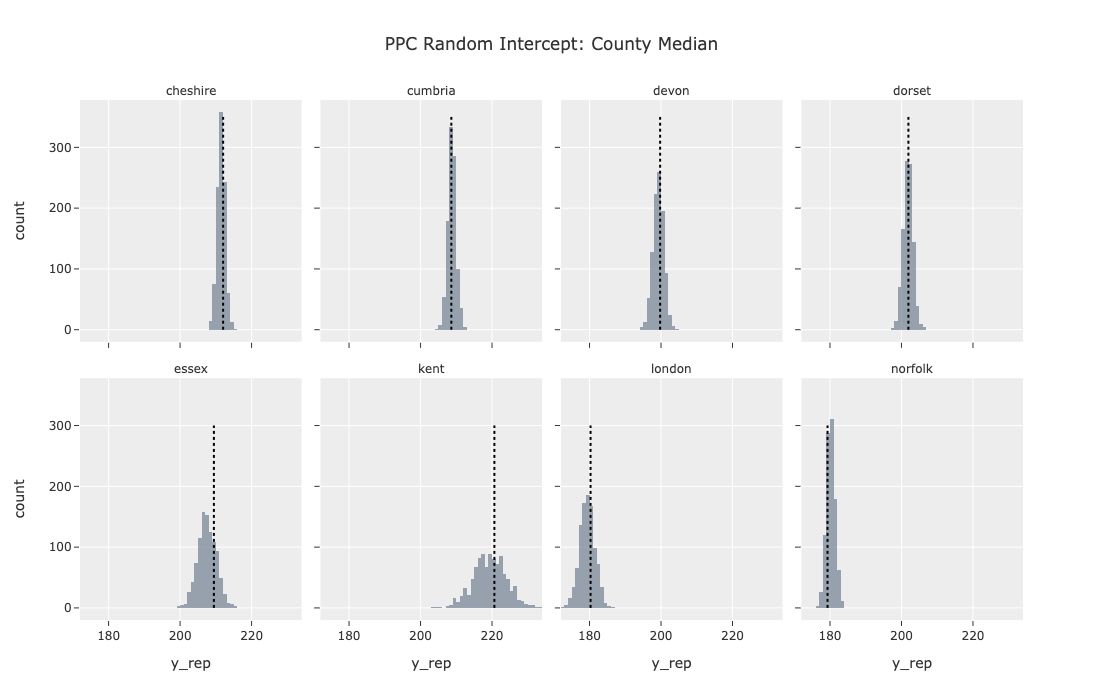

In [342]:
# same as above
fig = px.histogram(data_frame=rint_df, x='y_rep', facet_col='county', facet_col_wrap=4,
                   color='county', color_discrete_sequence=['slategray'], opacity=0.7,
                   template='ggplot2', title='PPC Random Intercept: County Median',
                   width=1000, height=700)

for i, m in enumerate(county_obs_medians[:4]):
    fig.add_scatter(x=[m, m], y=[0,350], mode='lines', 
                    row=2, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )
    
for i, m in enumerate(county_obs_medians[4:]):
    fig.add_scatter(x=[m, m], y=[0,300], mode='lines', 
                    row=1, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )

fig.update_traces(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

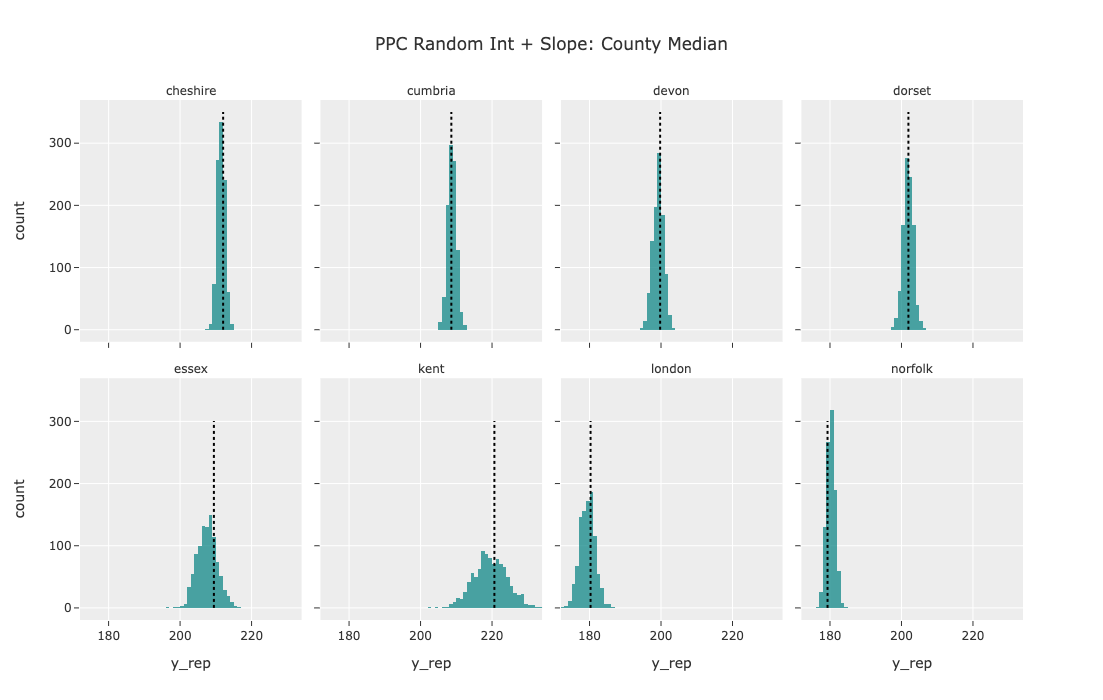

In [343]:
# same as above
fig = px.histogram(data_frame=rslope_df, x='y_rep', facet_col='county', facet_col_wrap=4,
                   color='county', color_discrete_sequence=['teal'], opacity=0.7,
                   template='ggplot2', title='PPC Random Int + Slope: County Median',
                   width=1000, height=700)

for i, m in enumerate(county_obs_medians[:4]):
    fig.add_scatter(x=[m, m], y=[0,350], mode='lines', 
                    row=2, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )
    
for i, m in enumerate(county_obs_medians[4:]):
    fig.add_scatter(x=[m, m], y=[0,300], mode='lines', 
                    row=1, col=(i+1), marker_color='black', 
                    showlegend=False, line_dash='dot' )

fig.update_traces(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))


## Leave-one-out Cross-validation (LOO CV, Marginal Predictive Checks)

### Calibration via Leave-one-out Probability Integral Transform (LOO-PIT)

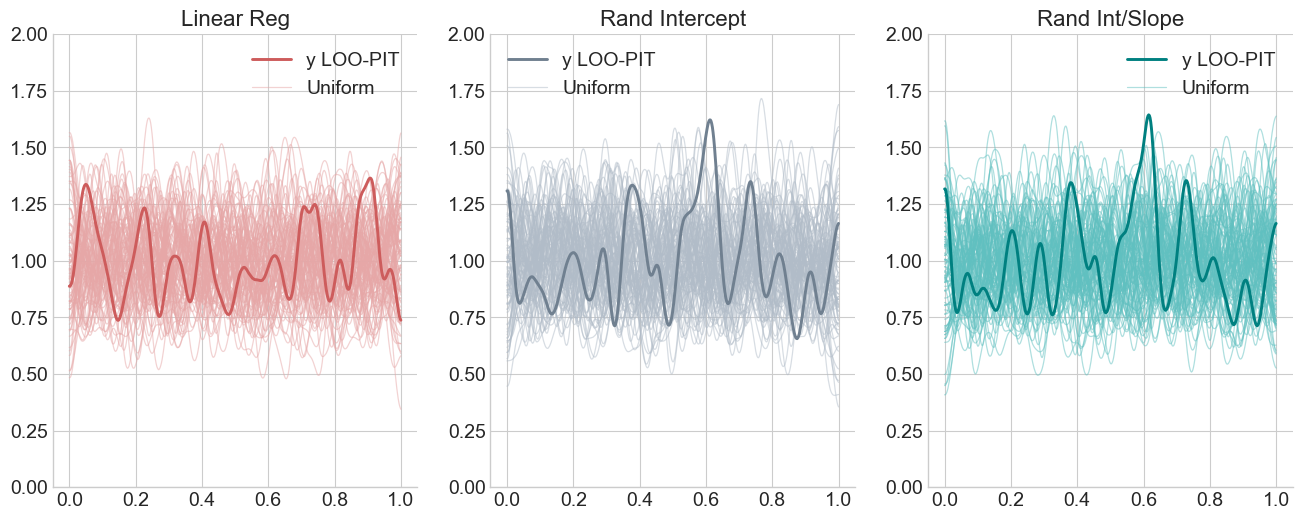

In [180]:
# use built-in pymc3 function
plt.style.use('arviz-colors')
fig2, ax2 = plt.subplots(1,3, figsize=(16,6))

pm.plot_loo_pit(lr_data, y='y', color='indianred', ax=ax2[0])
pm.plot_loo_pit(rint_data, y='y', color='slategray', ax=ax2[1])
pm.plot_loo_pit(rslope_data, y='y', color='teal', ax=ax2[2])

title = ['Linear Reg', 'Rand Intercept', 'Rand Int/Slope']
for i, f in enumerate(ax2):
    f.set(ylim=(0, 2), title=title[i])


### Predictive Accuracy (ELPD Comparisons, Outliers and Influencial points)

In [190]:
# Compute and compare 3 models LOO Predictive accuracy (ELPD)
df_loo_compare = pm.compare({"lin_reg": lr_data, "bayes_rintercept": rint_data,
                            "bayes_rslope": rslope_data}, ic='LOO',
                           seed=123)

df_loo_compare

rank      loo    p_loo    d_loo        weight       se  \
bayes_rintercept    0 -2146.05  10.0761        0       0.80173  19.7581   
bayes_rslope        1 -2147.49   11.751  1.43514       0.19827  16.3984   
lin_reg             2 -2494.04   2.3041  347.983  4.95353e-124  19.7277   

                       dse warning loo_scale  
bayes_rintercept         0   False       log  
bayes_rslope      0.321052   False       log  
lin_reg            18.7792   False       log

#### Pointwise ELPD comparison (i.e. PW ELPD differences)

In [228]:
# Compute LOO CV and store pointwise data
pw_lr_loo = pm.loo(lr_data, pointwise=True, var_name='y')
pw_rint_loo = pm.loo(rint_data, pointwise=True, var_name='y')
pw_rslope_loo = pm.loo(rslope_data, pointwise=True, var_name='y')

# compute pointwise differences between models ( Random Int vs LR, Random Int vs Rand Int/Slope)
diffs = np.c_[pw_rint_loo['loo_i'].values - pw_lr_loo['loo_i'].values, pw_rint_loo['loo_i'].values - pw_rslope_loo['loo_i'].values]

# Store in data frame with county labels and observation index
pw_loo = pd.DataFrame(diffs, columns=['rint_lr', 'rint_rslope'])
pw_loo['Index'] = np.arange(pw_loo.shape[0])
pw_loo['county'] = bounce_data.county.values

# Melt to make it easy plot counties by color
pw_loo_melt = pw_loo.melt(id_vars=['Index','county'], var_name='models', value_name='ELPD Pointwise Diff')

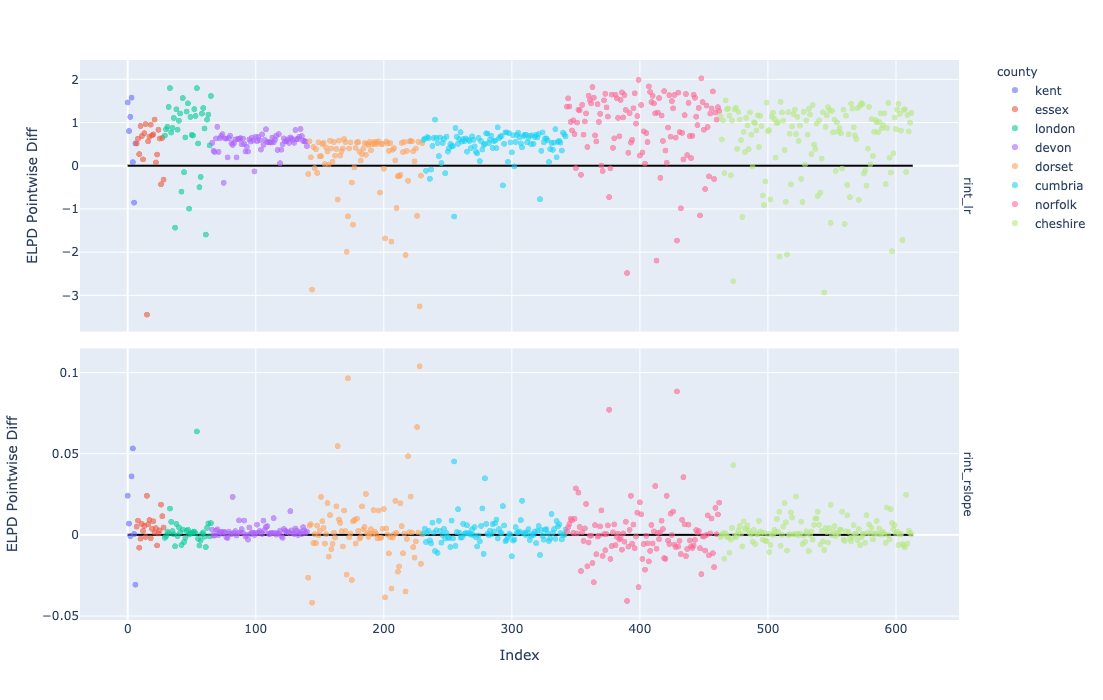

In [344]:
# use plotly express
elpd_fig = px.scatter(x='Index', y='ELPD Pointwise Diff', facet_row='models', color='county', 
                      data_frame=pw_loo_melt, opacity=0.6)

# plot 0 hline on each plot
for i in range(1,3):
    elpd_fig.add_scatter(x=[0, bounce_data.shape[0]], y=[0,0], mode='lines', 
                         row=i, col=1, marker_color='black', 
                         showlegend=False )

# Clean up  column titles, set yaxes free
elpd_fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
elpd_fig.update_yaxes(matches=None)
elpd_fig.update_layout(autosize=False,
                  width=900,
                  height=700)

#### Pareto-k hat diagnostic (seeking influential points)

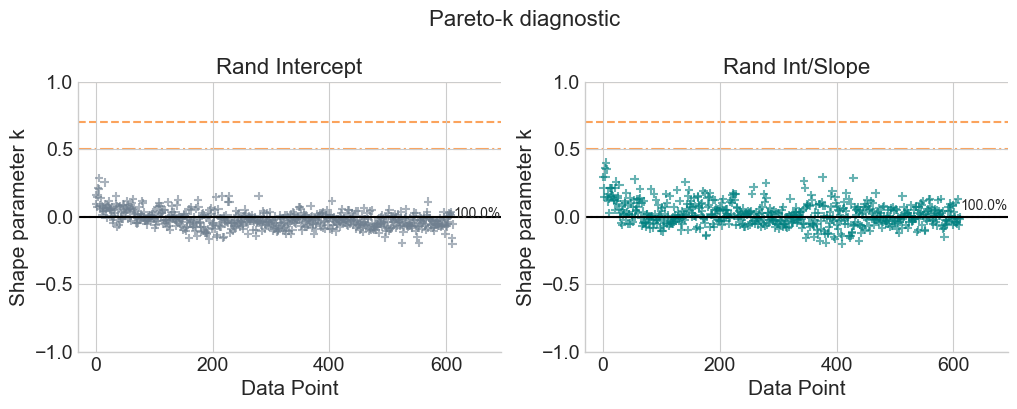

In [263]:
# Use pymc3 built-in functions
plt.style.use("arviz-whitegrid")
fig, ax = plt.subplots(1,2,figsize=(12, 4))

pm.plot_khat(pw_rint_loo, show_bins=True, color='slategray', 
             ax=ax[0], alpha=0.6)
pm.plot_khat(pw_rslope_loo, show_bins=True, color='teal', 
             ax=ax[1], alpha=0.6)

title = ['Rand Intercept', 'Rand Int/Slope']
plt.subplots_adjust(top=0.8)
fig.suptitle("Pareto-k diagnostic ", size=16)

#Add 0 hline to both plots as well as title
for i, f in enumerate(ax):
    f.axhline(0, color='black')
    f.set(title=title[i], ylim=(-1, 1))

    
pass



# Final Model

In [347]:
# summary of none random intercept parameters w/ 95% HDPI
pm.summary(rint_trace, var_names=['~^a'], filter_vars='regex', hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mu0           200.038  0.985   198.122    201.966      0.009    0.006   
std_age         1.812  0.431     0.996      2.667      0.005    0.004   
sd_Intercept   13.056  3.059     7.822     19.094      0.030    0.023   
sigma           7.962  0.229     7.505      8.398      0.002    0.001   

              ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
mu0            11670.0  11666.0   11687.0    6429.0    1.0  
std_age         6661.0   6624.0    6667.0    5898.0    1.0  
sd_Intercept   10341.0   8781.0   11821.0    6226.0    1.0  
sigma          12097.0  12064.0   12105.0    6360.0    1.0

In [369]:
# Load bokeh for plotly-like interactive experience
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [ ]:
# Necessary to get bokeh to render inline plots

# ! jupyter labextension install @jupyter-widgets/jupyterlab-manager
# ! jupyter labextension install @bokeh/jupyter_bokeh

In [395]:
# Use bokeh as backend instead of matplotlib, plot posterior estimates for random intercept w/ 95% HDPI
pm.forestplot(rint_data, kind='ridgeplot', 
              var_names=['^a'], filter_vars='regex', combined=True, 
              ridgeplot_alpha=0.5, hdi_prob=0.95, ridgeplot_quantiles=[0.5],
              linewidth=0, backend='bokeh', show=True, 
              backend_kwargs={'width':700, 'height':500, 'title':'Posterior Alpha Estimates'})
pass

INFO:numba.transforms:finding looplift candidates


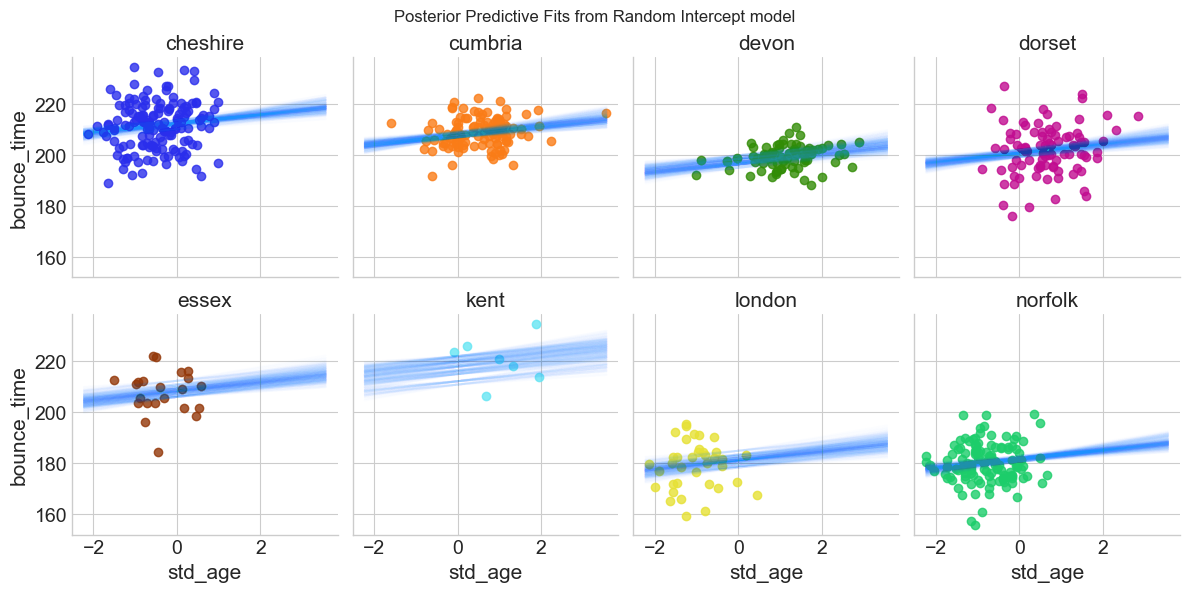

In [520]:
# Sample a couple of posterior samples for the random intercept and fixed slope values
post_pred = pm.sample_posterior_predictive(rint_trace, model=bayes_rintercept, 
                                           var_names=['a', 'std_age'], random_seed=123,
                                          samples=20, progressbar=False)

# Set xs for plotting
xs = np.linspace(bounce_data.std_age.min(),bounce_data.std_age.max(), 
                 num=50 )

# Multiply each sample by xs to get into right dimentions
slopes=post_pred['std_age'][:, None]*xs

# Plot observed data
g = sns.FacetGrid(bounce_data, col="county", hue='county', col_wrap=4)
g.map(plt.scatter, "std_age", "bounce_time", alpha=0.8).set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Posterior Predictive Fits from Random Intercept model')

# Plot posterior predictive fits for each county
for i, ax in enumerate(g.axes):
    for j in range(post_pred['a'].shape[0]):
        ax.plot(xs, (post_pred['a'][j,i] + slopes).T , alpha=0.01, color='dodgerblue')
        
pass